In [1]:
from rnn_lstm  import * 
%matplotlib inline

INFO:tensorflow:TensorFlow version1.13.1


### Data 
---
__ fetch data  __

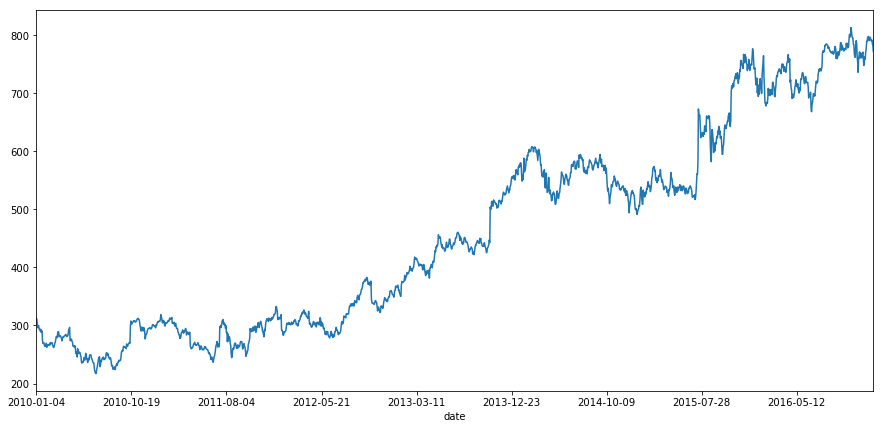

In [2]:
filefolder=["securities", "fundamentals", "prices", "prices-split-adjusted"]
 

symbol="GOOG"
df=fetch_raw(filefolder[3], symbol)
fig=df.copy()
fig.set_index('date', inplace=True)
fig['close'].plot(figsize=(15,7))
df.drop(['date','symbol'],1, inplace=True)

__ split/normalize data__

In [3]:
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size: {} {}\n\n".format(len(df_train), len(df_test)))

# scale the feature MinMax, build array
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(df_train.values)
x_test = min_max_scaler.transform(df_test.values)

Train and Test size: 1409 353




__ handle data (build time series) __

In [4]:
BATCH_SIZE=20
TIME_STEPS=21

def handle_data(x_train, x_test):
    #training dataset 
    x_t, y_t = build_timeseries(x_train, 1, TIME_STEPS)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE).reshape(-1, 1)
    
    #valid dataset 
    x_vad, y_vad = build_timeseries(x_test, 1,TIME_STEPS)
    x_vad = trim_dataset(x_vad, BATCH_SIZE)
    y_vad = trim_dataset(y_vad, BATCH_SIZE).reshape(-1, 1)
    
    #test dataset (raw)
    x_tt, y_tt = build_timeseries(x_test, 1,TIME_STEPS)
    return x_t, y_t, x_vad, y_vad, x_tt, y_tt

x_t, y_t, x_vad, y_vad, x_tt, y_tt=handle_data(x_train, x_test)

length of time-series i/o: (1388, 21, 5) (1388,)
length of time-series i/o: (332, 21, 5) (332,)
length of time-series i/o: (332, 21, 5) (332,)


### Model 
---
__ config __

In [5]:
class Config(): 
    n_layers = 2
    n_outputs=1
    keep_prob=1.0
    n_neurons = [200, 100] 
    learning_rate = 0.001
    n_epochs = 10
    train_set_size = x_t.shape[0]
    test_set_size = x_test.shape[0]

config=Config()

#### Define Graph

 

In [7]:
tf.reset_default_graph()
lstm_graph = tf.Graph()

with lstm_graph.as_default():
    X = tf.placeholder(tf.float32, [None, TIME_STEPS, x_t.shape[2]])
    y = tf.placeholder(tf.float32, [None, Config.n_outputs])
    
    #layers
    def _create_one_cell(layer, config):
        cell=tf.contrib.rnn.LSTMCell(config.n_neurons[layer], state_is_tuple=True)
        if config.keep_prob == 1.0:
            return cell
        else:
            return tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=config.keep_prob)
    multi_cell=tf.contrib.rnn.MultiRNNCell([_create_one_cell(_, config) for _ in range(config.n_layers)],state_is_tuple=True)
    val, _ = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
    
    #outputs
    stacked_rnn_outputs = tf.reshape(val, [-1, Config.n_neurons[-1]]) 
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, Config.n_outputs)
    outputs=tf.reshape(stacked_outputs, [-1, TIME_STEPS,  Config.n_outputs])
    outputs=outputs[:,TIME_STEPS-1,:] # keep only last output of seque
    
    #loss function
    loss = tf.reduce_mean(tf.square(outputs - y))   
    optimizer = tf.train.AdamOptimizer(learning_rate=Config.learning_rate) 
    training_op = optimizer.minimize(loss)
 

#### Run Graph


In [8]:
with tf.Session(graph=lstm_graph) as sess: 
    index_in_epoch = 0;
    perm_array  = np.arange(x_t.shape[0])
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./logs/summary', sess.graph)
    mse_train_record=[]
    mse_valid_record=[]
    for iteration in range(int(Config.n_epochs*Config.train_set_size/BATCH_SIZE)):
        x_batch, y_batch, index_in_epoch = get_next_batch(perm_array, index_in_epoch, x_t, y_t,BATCH_SIZE)  
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*Config.train_set_size/BATCH_SIZE) == 0:
            mse_train = loss.eval(feed_dict={X: x_t, y: y_t}) 
            mse_valid = loss.eval(feed_dict={X: x_vad, y: y_vad}) 
            mse_train_record.append(mse_train)
            mse_valid_record.append(mse_valid)
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*BATCH_SIZE/Config.train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_t})
    y_test_pred = sess.run(outputs, feed_dict={X: x_tt})
    

0.00 epochs: MSE train/valid = 0.086746/0.615584
5.00 epochs: MSE train/valid = 0.001412/0.001068


### Results

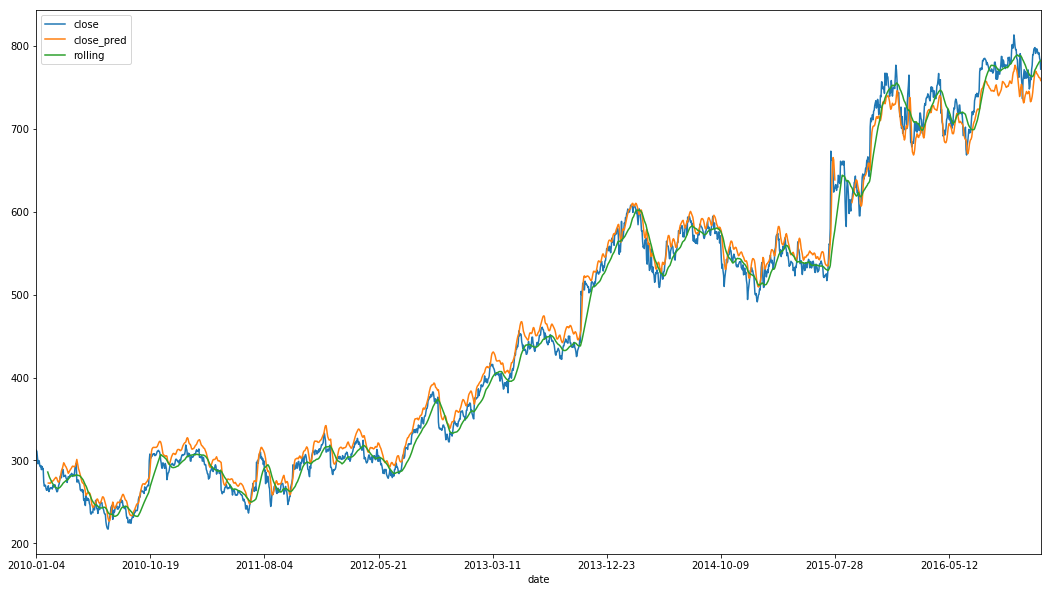

In [10]:
#Prediction curves 
scaler = MinMaxScaler()
scaler.fit_transform(df_train[['close']].values)

#train set
new_y_train=list(scaler.inverse_transform(y_train_pred).reshape(-1))
y_train=list(scaler.inverse_transform(y_t).reshape(-1))

#test set
new_y_test=list(scaler.inverse_transform(y_test_pred).reshape(-1))
y_test=list(scaler.inverse_transform(y_tt.reshape(-1,1)).reshape(-1))


#recover 
post_train=df_train.copy()
post_test=df_test.copy()
result=pd.concat([post_train,post_test])
y_new_train=[np.nan]*TIME_STEPS  +new_y_train+ [np.nan]*(df_train.shape[0]-len([np.nan]*TIME_STEPS  +new_y_train))
y_new_test=[np.nan]*TIME_STEPS  +new_y_test
result['close_pred']=y_new_train+y_new_test
result['rolling']=result['close'].rolling(TIME_STEPS).mean()
result['date']=fig.index
result.set_index('date', inplace=True)


result[['close','close_pred','rolling']].plot(figsize=(18,10));

__2. tensorboard --logdir logs/summary __

---